In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json

In [23]:
import pandas as pd

# PRELIM Analysis WAE / AAVE Data

In [7]:
def load_data(fp):
    data = []
    with open(fp) as f:
        for l in f.readlines():
            data.append(json.loads(l))
    return data

In [8]:
aave_data = load_data("./AAVE.jsonl")
wae_data = load_data("./WAE.jsonl")

In [10]:
aave_data[:1]

[{'text': "Sooo Manti Te'o was having a online/phone relationship with a guy pretendingto be a female -_-",
  'toxicity': 0.31963667,
  'severe_toxicity': 0.011291504,
  'insult': 0.071750276,
  'flirtation': 0.41202375,
  'profanity': 0.15283443,
  'sexually_explicit': 0.40147725,
  'threat': 0.009851551,
  'identity_attack': 0.07673789}]

In [11]:
wae_data[:1]

[{'text': "Manti Te'o was having a relationship via telephone/internet with a man pretending to be female.",
  'toxicity': 0.20172562,
  'severe_toxicity': 0.008392334,
  'insult': 0.04383647,
  'flirtation': 0.34389514,
  'profanity': 0.10425757,
  'sexually_explicit': 0.3934218,
  'threat': 0.011120236,
  'identity_attack': 0.04512853}]

In [22]:
aave_data, wae_data = pd.DataFrame(aave_data), pd.DataFrame(wae_data)

In [24]:
wae_stats = pd.DataFrame(wae_data).iloc[:,1:].describe()
aave_stats= pd.DataFrame(aave_data).iloc[:,1:].describe()

In [25]:
aave_stats - wae_stats

,toxicity,severe_toxicity,insult,flirtation,profanity,sexually_explicit,threat,identity_attack
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.060028,0.038876,0.044387,0.032048,0.060390,0.033062,0.011286,0.039266
std,0.011019,0.036036,0.020101,-0.011896,0.007004,0.002272,0.007124,0.064906
min,-0.002717,-0.000021,-0.000770,0.010897,0.000094,-0.000413,-0.000087,-0.000074
25%,0.018554,0.000701,0.004362,0.045090,0.005397,0.004807,0.000466,0.000740
50%,0.088689,0.004807,0.033057,0.043668,0.052226,0.024036,0.001631,0.004382
75%,0.167796,0.146526,0.121364,0.027188,0.241750,0.102294,0.017698,0.026858
max,-0.007535,0.052360,-0.029740,0.000000,-0.004733,-0.017883,-0.107112,0.000000


In [21]:
import matplotlib.pyplot as plt

/var/folders/cl/_rfsk31s4z983g2y2zq9cvb00000gn/T/ipykernel_87818/2694445964.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


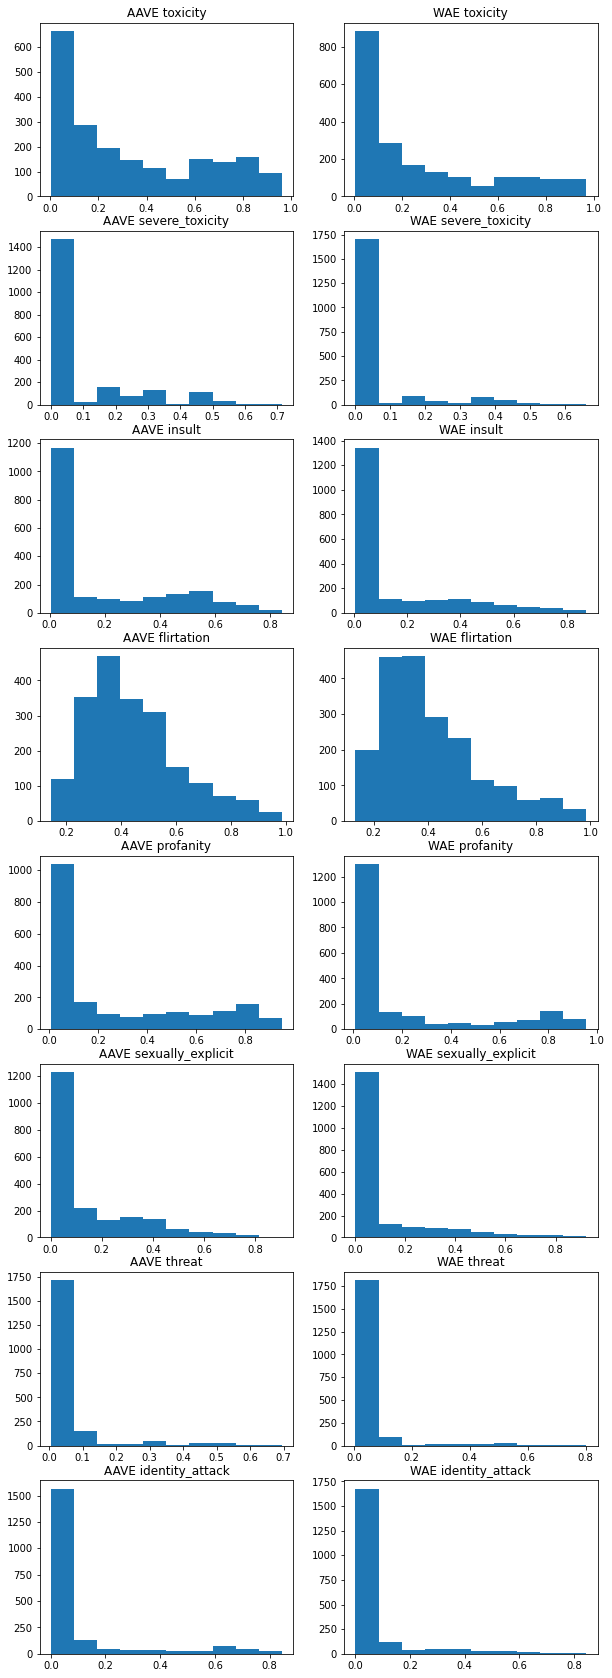

In [39]:
fig, ax = plt.subplots(nrows=len(aave_data.columns[1:]), ncols=2, figsize=(10, 30))
for i, cname in enumerate(aave_data.columns[1:]):
    
    ax[i, 0].hist(aave_data[cname])
    ax[i,0].set_title(f"AAVE {cname}")
    
    ax[i,1].hist(wae_data[cname])
    ax[i,1].set_title(f"WAE {cname}")

fig.show()
    

# Prelim Analysis AAL Dataset

In [41]:
def load_aal(fp):
    return pd.read_csv(fp)

In [44]:
# lets confirm if one is a subset of the other:
feval, fprompts = load_aal("./AAL dataset/final_eval_aal.csv"), load_aal("./AAL dataset/final_prompts_aal.csv")

In [48]:
s1, s2, s3, s4 = set(feval['aal_text']), set(feval['wme_text']), set(fprompts['aal_text']), set(fprompts['wme_text'])

In [49]:
len(s1), len(s2), len(s3), len(s4)

(274, 274, 70, 72)

In [55]:
# okay so from this we know that there are instances in which we have duplicate text but only across AAL and WME text (which makes sense)
for i in range(4):
    for j in range(i+1,4):
        print(["s1", "s2", "s3", "s4"][i], ["s1", "s2", "s3", "s4"][j], len([s1,s2,s3,s4][i].intersection([s1,s2,s3,s4][j])))

s1 s2 31
s1 s3 0
s1 s4 0
s2 s3 0
s2 s4 0
s3 s4 5


In [ ]:
# okay we can now run our reward models on this data

## AAL Dataset/Loader

In [87]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class AALDataset(Dataset):
    def __init__(self, dataframe):
        """
        Initialize data by storing the dataframe.
        Assume dataframe 'aal' has three columns, and we are interested in the last two.
        """
        self.data = dataframe.to_numpy()[:,1:]

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve a single item from the dataset at the specified index.
        """
        aae, wae = self.data[idx, :]
        # Convert row to tensor: assuming the columns are categorical strings,
        # you might later need to handle categorical conversion. Here we return them as is.
        return {'aae': aae, 'wae' : wae}

# Example usage:
# Assuming 'aal' is your pandas DataFrame
dataset = AALDataset(feval)
# Parameters for the DataLoader
batch_size = 4  # example batch size, adjust as needed
shuffle = False  # shuffle the data for training purposes, set False if not needed

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Example of iterating over DataLoader
for batch in dataloader:
    print(batch)  # Each batch is a list of strings from the last two columns of 'aal'
    break

{'aae': ["I see 20-year-olds who can barely use Microsoft Office to complete their assignments, and suddenly, I'm grateful for my grade 7 computer class that at the time, I thought was completely useless because Mavis Beacon had already taught me how to type and I was already quite comfortable with Word and PowerPoint.", "so I'm definitely gonna be there.", 'Then she drinking wine too.', 'For instance, if you get pregnant, your child will have a secured 2 parent household and a more stable setting.'], 'wae': ["I see 20-year-olds who can barely use Microsoft Office to complete their assignments, and suddenly, I'm grateful for my grade 7 computer class that at the time, I thought was completely useless because Mavis Beacon had already taught me how to type and I was quite comfortable with Word and PowerPoint", 'So, im definitely going to be there.', 'Then, she is drinking wine too', 'For instance, if you get pregnant, your child will have a secured 2 parent household and a more stable se

In [1]:
# lets load a reward model:
from transformers import AutoTokenizer, Pipeline, QuantoConfig, AutoModel
reward_model_name = "weqweasdas/RM-Mistral-7B"
qconfig = QuantoConfig(weights='float8') # should this be int8?
pipeline_name = "sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(reward_model_name)
# tokenizer = 

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [11]:
# This is how to tokenize this
tokenizer.apply_chat_template([{"role":"user", "content":"This is a sample prompt"}], tokenize=False, add_generation_prompt=False).replace(tokenizer.bos_token, "")

'[INST] This is a sample prompt [/INST]'

In [13]:
model = AutoModel.from_pretrained(reward_model_name, quantization_config=qconfig)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]